In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = "retina"

Let’s consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [14]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100,2))
train_labels = np.zeros(100)

#adding second class
train_data = np.r_[train_data,np.random.normal(size=(100,2),loc=2)] # loc referes to mean
train_labels = np.r_[train_labels,np.ones(100)]

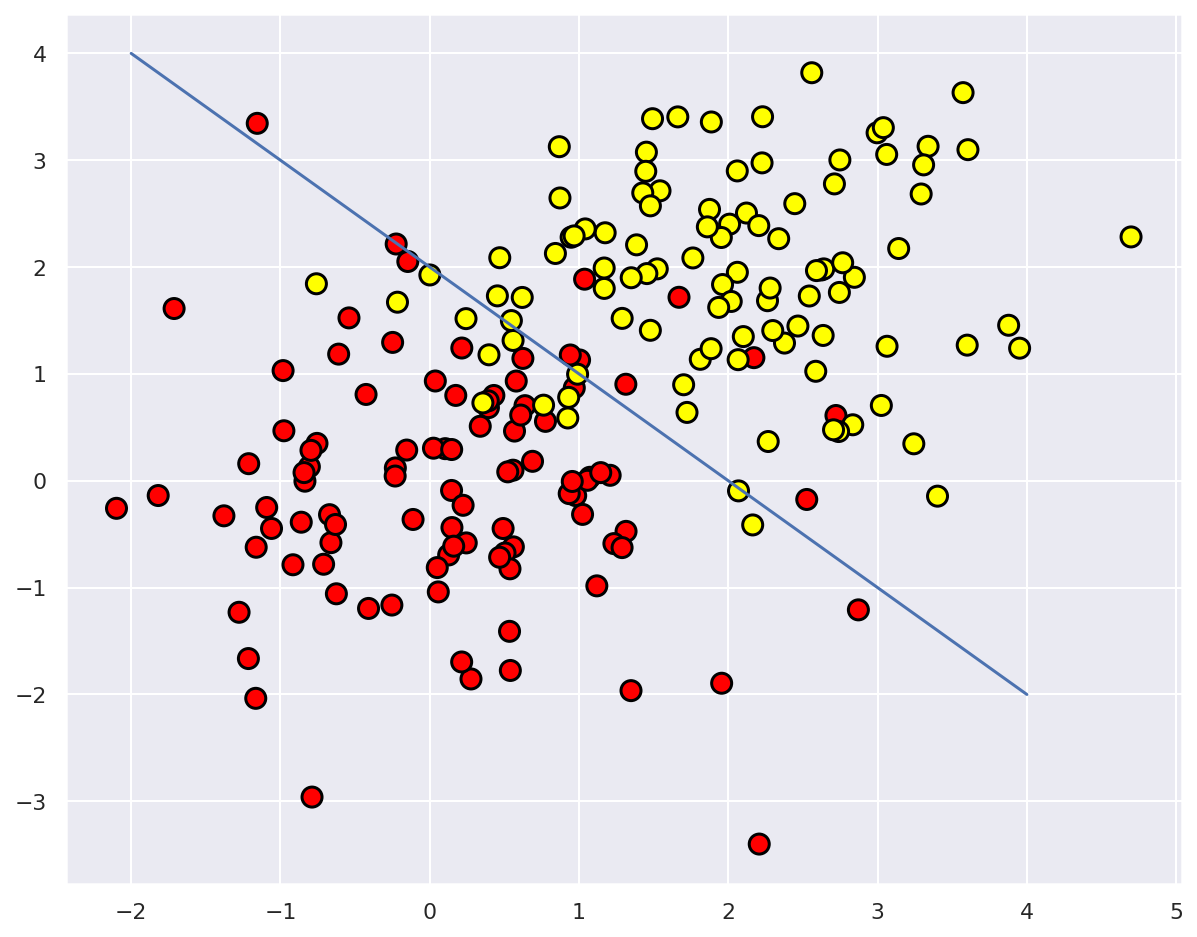

In [15]:
# lets plot our dataset
plt.figure(figsize=(10,8))
plt.scatter(
    train_data[:,0], # first feature
    train_data[:,1], # second feature
    c = train_labels, # hue
    s = 100,
    cmap="autumn",
    edgecolors="black",
    linewidths=1.5
)

plt.plot(range(-2,5),range(4,-3,-1)) # approximate decision boundary

Let’s try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let’s visualize the resulting separating boundary.

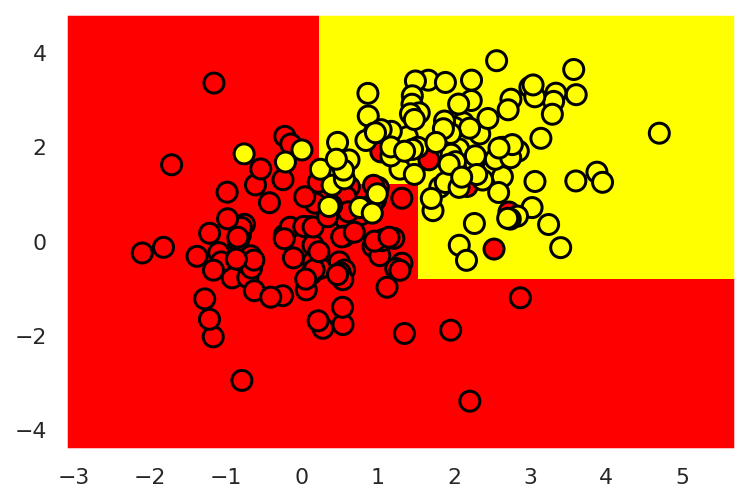

In [16]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1 # first feature
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1 # second feature
    # generates all points of the given two features in 2D space
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data) # xx: x co-ordinates, yy: y co-ordinates
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

In [17]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [18]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="decision_tree1.png",
)

### Decision trees and nearest neighbors method in a customer churn prediction task

In [19]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [26]:
df = pd.read_csv(DATA_PATH+"telecom_churn.csv")

# df["International plan"].value_counts()
# df["Voice mail plan"].value_counts()

# International plan and Voice mail plan are encoded as object
# lets turn them numeric representaion


df["International plan"] = pd.factorize(df["International plan"])[0] # we just need the codes
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]

df["Churn"] = df["Churn"].astype("int")
states = df["State"]

y = df["Churn"]
df.drop(["State","Churn"],axis=1,inplace=True)

In [27]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [28]:
df.shape

(3333, 18)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   Area code               3333 non-null   int64  
 2   International plan      3333 non-null   int64  
 3   Voice mail plan         3333 non-null   int64  
 4   Number vmail messages   3333 non-null   int64  
 5   Total day minutes       3333 non-null   float64
 6   Total day calls         3333 non-null   int64  
 7   Total day charge        3333 non-null   float64
 8   Total eve minutes       3333 non-null   float64
 9   Total eve calls         3333 non-null   int64  
 10  Total eve charge        3333 non-null   float64
 11  Total night minutes     3333 non-null   float64
 12  Total night calls       3333 non-null   int64  
 13  Total night charge      3333 non-null   float64
 14  Total intl minutes      3333 non-null   

Let’s allocate 70% of the set for training (X_train, y_train) and 30% for the hold-out set (X_holdout, y_holdout). The hold-out set will not be involved in tuning the parameters of the models. We’ll use it at the end, after tuning, to assess the quality of the resulting model.

In [ ]:
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

